In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LogNorm
import os

from hazma.scalar_mediator import ScalarMediator
from hazma.pseudo_scalar_mediator import PseudoScalarMFV
from hazma.vector_mediator import VectorMediator

from hazma.parameters import neutral_pion_mass as mpi0
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import (energy_res_fermi,
                                                               energy_res_e_astrogam,
                                                               A_eff_e_astrogam,
                                                               A_eff_comptel,
                                                               egret_diffuse,
                                                               fermi_diffuse,
                                                               comptel_diffuse,
                                                               gc_target,
                                                               gc_bg_model,
                                                               solid_angle)
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum
from hazma.cmb import vx_cmb

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Profiling

In [2]:
import cProfile

s_theta = 0.5
sm_hp = ScalarMediator(mx=1., ms=1000., gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100  # 100
sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

In [5]:
cProfile.run('sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)')

         33947044 function calls (33946235 primitive calls) in 34.259 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   34.259   34.259 <string>:1(<module>)
      101    0.000    0.000    0.008    0.000 __init__.py:184(gamma_ray_lines)
      101    0.000    0.000   23.187    0.230 __init__.py:187(spectra)
      101    0.000    0.000    0.001    0.000 _methods.py:28(_amin)
   202303    0.089    0.000    0.722    0.000 _methods.py:31(_sum)
      202    0.000    0.000    0.002    0.000 _methods.py:40(_all)
   101202    0.488    0.000    1.341    0.000 _util.py:192(_asarray_validated)
    90475    0.111    0.000    1.122    0.000 arraysetops.py:113(unique)
    90475    0.486    0.000    0.807    0.000 arraysetops.py:256(_unique1d)
   101202    0.050    0.000    0.099    0.000 base.py:1187(isspmatrix)
      101    0.002    0.000   34.252    0.339 compute_limits.py:151(binned_limit)
     1010    0.005 

## Load relic density curve

In [3]:
rd_mxs, rd_lims = np.loadtxt("relic_abundance.dat", delimiter=",").T
rd_mxs = 1e3*10.**rd_mxs  # convert GeV -> MeV
rd_lims = 10.**rd_lims

# Scalar mediator

## Setup

In [2]:
s_theta = 0.5
sm_hp = ScalarMediator(mx=1., ms=1000., gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100  # 100
sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [3]:
sm_lims_e_astrogam = sm_hp.unbinned_limits(sm_mxs, target_params=gc_target, bg_model=gc_bg_model)

6
6
7
6


/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:44: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:46: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:50: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


89
78
80
91
48
75
103
88
68
100
92
58
97
78
84
94
66
66
14
15
18
17


/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


15
13
14
14
11
13
12
12
11
11
11
11
33
53
71
54
66
39
62
29
58
59
55
32
46
67
76
69
58
67
55
66
69
67
40
39
35
30
23
22
22
28
37
41
36
35
28
23
59
49
24
24
22
51
24
36
34
35
69
28
71
65
26
32
29
48
66
36
44
45
43
55
55
53
60


In [ ]:
sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)

In [ ]:
sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)
sm_lims_comptel = sm_hp.binned_limits(sm_mxs, comptel_diffuse)
sm_lims_fermi = sm_hp.binned_limits(sm_mxs, fermi_diffuse)

In [ ]:
# sm_lims_cmb = sm_hp.cmb_limits(sm_mxs)

### Save results

In [ ]:
np.savetxt("data/sm_lims_egret.csv",
           np.array([sm_mxs, sm_lims_egret]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/sm_lims_comptel.csv",
           np.array([sm_mxs, sm_lims_comptel]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/sm_lims_fermi.csv",
           np.array([sm_mxs, sm_lims_fermi]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

np.savetxt("data/sm_lims_e_astrogam.csv",
           np.array([sm_mxs, sm_lims_e_astrogam]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/sm_lims_cmb.csv",
#            np.array([sm_mxs, sm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [ ]:
# sm_mxs, sm_lims_egret = np.loadtxt("data/sm_lims_egret.csv", delimiter=",").T
# sm_mxs, sm_lims_comptel = np.loadtxt("data/sm_lims_comptel.csv", delimiter=",").T
# sm_mxs, sm_lims_fermi = np.loadtxt("data/sm_lims_fermi.csv", delimiter=",").T
# sm_mxs, sm_lims_e_astrogam = np.loadtxt("data/sm_lims_e_astrogam.csv", delimiter=",").T
sm_mxs, sm_lims_cmb = np.loadtxt("data/sm_lims_cmb.csv", delimiter=",").T

## Plot results

In [ ]:
plt.figure(figsize=(8, 4))

plt.plot(sm_mxs, sm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(sm_mxs, sm_lims_egret, label="EGRET", color=colors[1])
plt.plot(sm_mxs, sm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(sm_mxs, sm_lims_e_astrogam, label="e-ASTROGAM", color=colors[3])
plt.plot(sm_mxs, (1.0e-3 / vx_cmb(sm_mxs, x_kd=1e-6))**2 * sm_lims_cmb, label=r"CMB, $x_{\mathrm{kd}} = 10^{-6}$", color="black")
# plt.plot(sm_mxs, (1.0e-3 / vx_cmb(sm_mxs, x_kd=1e-4))**2 * sm_lims_cmb, label=r"CMB, $x_{\mathrm{kd}} = 10^{-4}$", color="black")
plt.plot(rd_mxs, rd_lims, '--', label="Thermal relic", color="black", alpha=0.4)

plt.xlim(sm_mxs[[0, -1]])
plt.ylim([1e-30,1e-23])
# plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_0$ (cm$^3$/s)")  #  * (v_\chi / v_0)^2
plt.title("Scalar mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("figures/sm_sigmav_limits.pdf")

In [ ]:
import os
os.system('say "Done computing limits"')

# Pseudoscalar mediator

## Setup

Use the benchmark parameters from the 2HDM + pseudoscalar singlet UV completion

In [4]:
s_theta = 0.5
psm = PseudoScalarMFV(mx=200., mp=1e3, gpxx=1., gpuu=1., gpdd=-1., gpll=0., gpGG=1., gpFF=7./9.)

# Masses to scan over
mx_min, mx_max, n_mxs = 200., 250., 100  # 100
psm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [ ]:
psm_lims_e_astrogam = psm.unbinned_limits(psm_mxs, target_params=gc_target, bg_model=gc_bg_model)

In [ ]:
psm_lims_egret = psm.binned_limits(psm_mxs, egret_diffuse)

In [ ]:
psm_lims_comptel = psm.binned_limits(psm_mxs, comptel_diffuse)

In [ ]:
psm_lims_fermi = psm.binned_limits(psm_mxs, fermi_diffuse)

In [ ]:
psm_lims_cmb = psm.cmb_limits(psm_mxs)

Start time: 4:35pm

End time: 5:15pm

### Save results

In [ ]:
# np.savetxt("data/psm_lims_e_astrogam.csv",
#            np.array([psm_mxs, psm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
# np.savetxt("data/psm_lims_egret.csv",
#            np.array([psm_mxs, psm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
# np.savetxt("data/psm_lims_comptel.csv",
#            np.array([psm_mxs, psm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
# np.savetxt("data/psm_lims_fermi.csv",
#            np.array([psm_mxs, psm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
# np.savetxt("data/psm_lims_cmb.csv",
#            np.array([psm_mxs, psm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [10]:
os.system("say 'Done'")

0

## Load previously computed constraints

In [4]:
# psm_mxs, psm_lims_egret = np.loadtxt("data/psm_lims_egret.csv", delimiter=",").T
# psm_mxs, psm_lims_comptel = np.loadtxt("data/psm_lims_comptel.csv", delimiter=",").T
# psm_mxs, psm_lims_fermi = np.loadtxt("data/psm_lims_fermi.csv", delimiter=",").T
# psm_mxs, psm_lims_e_astrogam = np.loadtxt("data/psm_lims_e_astrogam.csv", delimiter=",").T
# psm_mxs, psm_lims_cmb = np.loadtxt("data/psm_lims_cmb.csv", delimiter=",").T

## Plot results

* Fermi limits are weaker since the gamma ray line is the only spectral feature in its lowest-energy bin ($[153, 276]$ MeV), and Br$(\bar{\chi}\chi \to \gamma\gamma)$ decreases as $m_\chi$ increases.
* Feature at 205 MeV comes from the window switching from including the $3\pi$ and $\gamma\gamma$ peaks to just including the $3\pi$ peak. Could certainly get a better limit by using two energy windows: our analysis is conservative/simplistic!

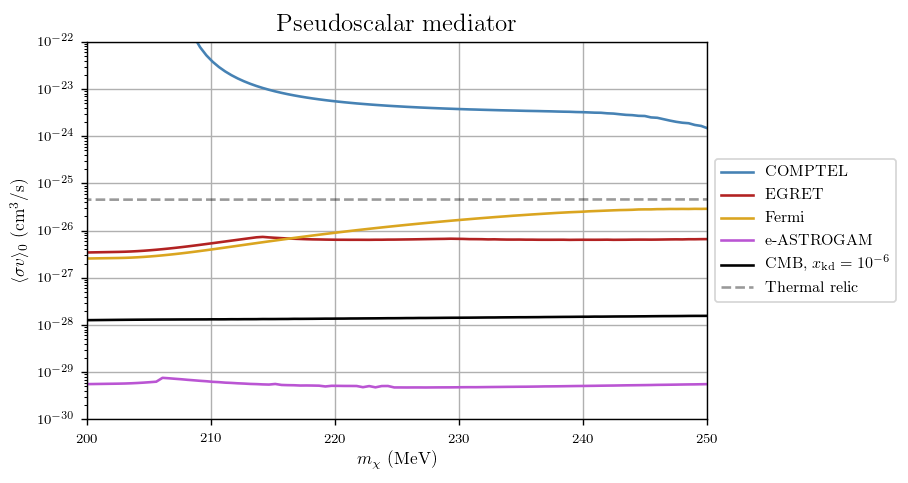

In [22]:
plt.figure(figsize=(8, 4))

plt.plot(psm_mxs, psm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(psm_mxs, psm_lims_egret, label="EGRET", color=colors[1])
plt.plot(psm_mxs, psm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(psm_mxs, psm_lims_e_astrogam, label="e-ASTROGAM", color=colors[3])
plt.plot(psm_mxs, psm_lims_cmb, label=r"CMB, $x_{\mathrm{kd}} = 10^{-6}$", color="black")
plt.plot(rd_mxs, rd_lims, '--', label="Thermal relic", color="black", alpha=0.4)

plt.xlim(psm_mxs[[0, -1]])
plt.ylim([1e-30, 1e-22])
# plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_0$ (cm$^3$/s)")  #  * (v_\chi / v_0)^2
plt.title("Pseudoscalar mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("figures/psm_mfv_sigmav_limits.pdf")

In [ ]:
import os
os.system('say "Done computing limits"')

# Vector mediator

## Setup

In [8]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [9]:
vm_lims_comptel = vm.binned_limits(vm_mxs, comptel_diffuse)
vm_lims_egret = vm.binned_limits(vm_mxs, egret_diffuse)
vm_lims_fermi = vm.binned_limits(vm_mxs, fermi_diffuse)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [10]:
vm_lims_e_astrogam = vm.unbinned_limits(vm_mxs, target_params=gc_target, bg_model=gc_bg_model)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  lim = prefactor * n_sigma / (-limit_obj.fun)


In [ ]:
# vm_lims_cmb = vm.cmb_limits(vm_mxs)

In [ ]:
# np.savetxt("data/vm_lims_comptel.csv",
#            np.array([vm_mxs, vm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_egret.csv",
#            np.array([vm_mxs, vm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_fermi.csv",
#            np.array([vm_mxs, vm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_e_astrogam.csv",
#            np.array([vm_mxs, vm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/vm_lims_cmb.csv",
#            np.array([vm_mxs, vm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [ ]:
vm_mxs, vm_lims_egret = np.loadtxt("data/vm_lims_egret.csv", delimiter=",").T
vm_mxs, vm_lims_comptel = np.loadtxt("data/vm_lims_comptel.csv", delimiter=",").T
vm_mxs, vm_lims_fermi = np.loadtxt("data/vm_lims_fermi.csv", delimiter=",").T
vm_mxs, vm_lims_e_astrogam = np.loadtxt("data/vm_lims_e_astrogam.csv", delimiter=",").T
vm_mxs, vm_lims_cmb = np.loadtxt("data/vm_lims_cmb.csv", delimiter=",").T

## Plot results

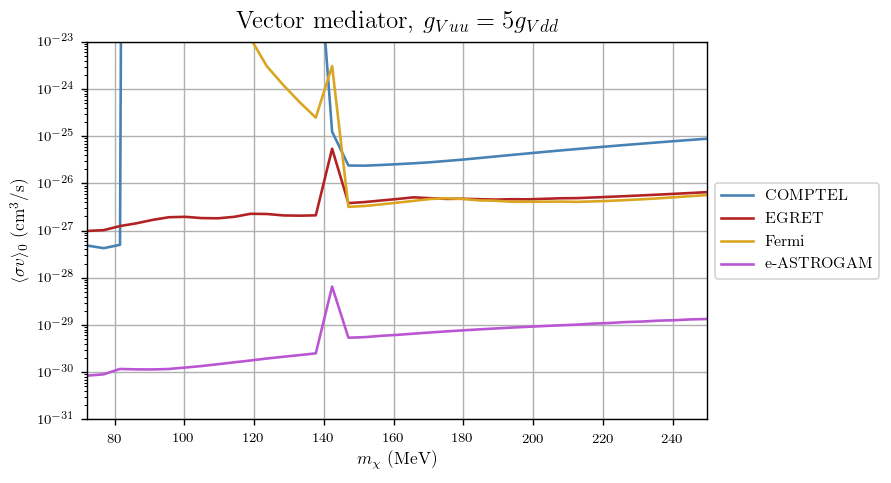

In [12]:
plt.figure(figsize=(8, 4))

plt.plot(vm_mxs, vm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(vm_mxs, vm_lims_egret, label="EGRET", color=colors[1])
plt.plot(vm_mxs, vm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(vm_mxs, vm_lims_e_astrogam, label="e-ASTROGAM", color=colors[3])
# plt.plot(vm_mxs, vm_lims_cmb, label="CMB", color="black")
# plt.plot(rd_mxs, rd_lims, '--', label="Thermal relic", color="black", alpha=0.4)

plt.xlim(vm_mxs[[1, -1]])
plt.ylim([1e-31,1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_0$ (cm$^3$/s)")
plt.title(r"Vector mediator, $g_{Vuu} = %i g_{Vdd}$" % (vm.gvuu/vm.gvdd))

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig("figures/vm_sigmav_limits.pdf")

In [ ]:
import os
os.system('say "Done computing limits"')

## Scratch: checking detected spectrum

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


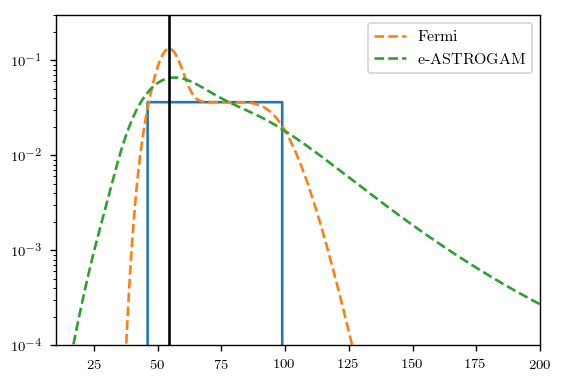

In [2]:
e_gam_min, e_gam_max, n_e_gams = 10, 1000., 200
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

vm = VectorMediator(mx=100., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)
e_cm = 2.*vm.mx*(1+0.5*1e-6)

dndes_det_fermi = get_detected_spectrum(lambda es, e_cm: vm.spectra(es, e_cm)["total"],
                                        vm.gamma_ray_lines,
                                        10, 1000, e_cm, energy_res_fermi)

dndes_det_e_a = get_detected_spectrum(lambda es, e_cm: vm.spectra(es, e_cm)["total"],
                                      vm.gamma_ray_lines,
                                      10, 1000, e_cm, energy_res_e_astrogam)

plt.plot(e_gams, vm.spectra(e_gams, e_cm)["total"])
plt.plot(e_gams, dndes_det_fermi(e_gams), '--', label="Fermi")
plt.plot(e_gams, dndes_det_e_a(e_gams), '--', label="e-ASTROGAM")
plt.axvline(vm.gamma_ray_lines(e_cm)["pi0 g"]["energy"], color='k')

plt.xlim(10, 200)
plt.ylim(1e-4, 3e-1)
plt.legend()
plt.yscale("log")

## Look out how e-ASTROGAM and CMB constraints vary with couplings

In [52]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=1., gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 280, 300, 50
vm_mxs_no_med_ann = np.linspace(mx_min, mx_max, n_mxs)

# Coupling ratios
ratios = np.array([-2, -1., 0., 0.25, 0.5, 0.75, 1.])

# Set up the colormap
cmap = cm.viridis_r
norm = Normalize(vmin=ratios[0], vmax=ratios[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(ratios)

In [39]:
# Compute ASTROGAM limits for the different couplings
vm_lims_e_astrogam_gvdd = []

for ratio in ratios:
    vm.gvdd = ratio * vm.gvuu
    vm_lims_e_astrogam_gvdd.append(vm.unbinned_limits(vm_mxs, target_params=gc_target, bg_model=gc_bg_model))

In [141]:
# Compute CMB limits for the different couplings
vm_lims_cmb_gvdd = []

for ratio in ratios:
    vm.gvdd = ratio * vm.gvuu
    vm_lims_cmb_gvdd.append(vm.cmb_limits(vm_mxs))

In [ ]:
plt.figure(figsize=(8, 4))

for i, (ratio, lims, cmb) in enumerate(zip(ratios, vm_lims_e_astrogam_gvdd, vm_lims_cmb_gvdd)):
    plt.plot(vm_mxs, lims, color=m.to_rgba(ratio))
    plt.plot(vm_mxs, cmb, '--', color=m.to_rgba(ratio), alpha=0.7)

plt.text(131, 5.5e-29, "CMB", fontdict={"fontsize": 9})
plt.text(130.5, 3.5e-30, "e-ASTROGAM", fontdict={"fontsize": 9})

# Formatting
plt.xlim(130, 180)
plt.ylim(2e-30, 1e-27)
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_0$ (cm$^3$/s)")
plt.title(r"Vector mediator")
# plt.legend()

plt.gcf().colorbar(m, ax=plt.gca()).set_label(r"$g_{Vdd} / g_{Vuu}$")

# plt.savefig("figures/vm_sigmav_limits_coupling_dependence.pdf")

## Limits when annihilating into $V V$

The result is not so interesting: the limit is the same as for $g_{Vuu} = g_{Vdd}$, but a factor of $\sim 1.5 - 2$ weaker since there are more photons but they have lower energy.

In [76]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=1., gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 140, 280, 50
vm_mxs_no_med_ann = np.linspace(mx_min, mx_max, n_mxs)

vm.gvdd = vm.gvuu
vms_no_med_ann = vm.unbinned_limits(vm_mxs_no_med_ann, target_params=gc_target, bg_model=gc_bg_model, energy_res=lambda e: 0.01)

In [77]:
vm = VectorMediator(mx=1., mv=140., gvxx=1., gvuu=1., gvdd=0.1, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 140, 280, 50
vm_mxs_med_ann = np.linspace(mx_min, mx_max, n_mxs)

vm.gvdd = 0.75 * vm.gvuu
vms_med_ann = vm.unbinned_limits(vm_mxs_med_ann, target_params=gc_target, bg_model=gc_bg_model, energy_res=lambda e: 0.01)

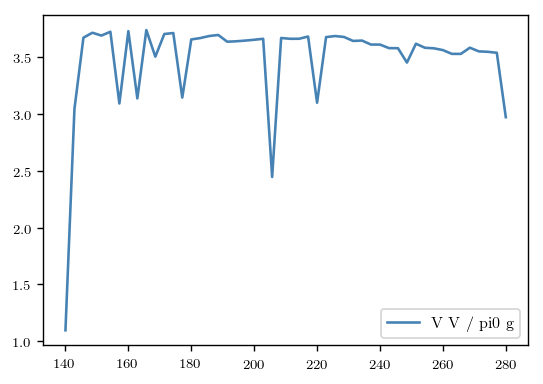

In [80]:
plt.plot(vm_mxs_no_med_ann, vms_med_ann / vms_no_med_ann, label="V V / pi0 g")

plt.legend()

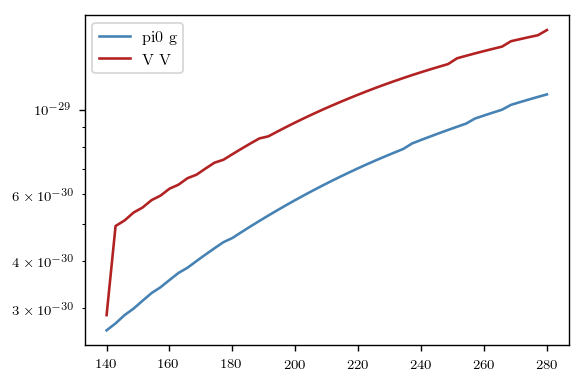

In [68]:
plt.plot(vm_mxs_no_med_ann, vms_no_med_ann, label="pi0 g")
plt.plot(vm_mxs_med_ann, vms_med_ann, label="V V")

plt.legend()
plt.yscale("log")

In [79]:
import os
os.system('say "Done computing limits"')

0

# Scratch/testing

In [ ]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import energy_res_comptel
import matplotlib.cm as cm
from matplotlib.colors import Normalize

vm = VectorMediator(mx=1., mv=201., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# mx_min, mx_max, n_mxs = 70, 200., 4
# mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)
mxs = np.array([100.])

cmap = cm.viridis
norm = Normalize(vmin=np.log10(mxs[0]), vmax=np.log10(mxs[-1]))

e_gams = np.logspace(0, np.log10(300), 300)

for mx in mxs:
    vm.mx = mx
    e_cm = 2.*vm.mx*(1.+0.5*1e-6)

    dnde_det = get_detected_spectrum(e_gams, vm.spectra(e_gams, e_cm)["total"], *vm.gamma_ray_lines(e_cm), energy_res=energy_res_comptel)
    
    plt.loglog(e_gams, dnde_det(e_gams), color=cmap(norm(np.log10(mx))), label="%.1f" % mx)
    
plt.legend()
plt.ylim(1e-10, 1e0)

In [ ]:
for fm in [comptel_diffuse, egret_diffuse, fermi_diffuse]:
    print fm.bins[0][0], fm.bins[-1][-1]

In [ ]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

mx = 200.
vm.mx = mx
e_cm = 2.*vm.mx * (1. + 0.5*1e-6)

e_gams = np.logspace(np.log10(A_eff_e_astrogam.x[0])-1,
                     np.log10(A_eff_e_astrogam.x[-1])+1, 75)
dndes = vm.spectra(e_gams, e_cm)["total"]

dnde_det = get_detected_spectrum(e_gams, dndes, *vm.gamma_ray_lines(e_cm), energy_res=energy_res_e_astrogam)

In [ ]:
e_min = max(A_eff_e_astrogam.x[0],
            dnde_det.x[np.where(dnde_det.y)[0][0]])
e_max = min(A_eff_e_astrogam.x[-1],
            dnde_det.x[np.where(dnde_det.y)[0][-1]])
e_dnde_max = dnde_det.x[np.argmax(dnde_det.y)]
print(e_min, e_max, e_dnde_max)

e_a_0 = 10.**(0.5 * (np.log10(e_dnde_max) + np.log10(e_min)))
e_b_0 = 10.**(0.5 * (np.log10(e_max) + np.log10(e_dnde_max)))

In [ ]:
plt.loglog(e_gams, dnde_det(e_gams))
plt.loglog(2*[e_a_0], [1e-100, 1e0])
plt.loglog(2*[e_b_0], [1e-100, 1e0])

# Minimal examples of how to set limits
Any of the three blocks below can be run without needing to set anything else up.

Unbinned (ie, projected) limits:

In [3]:
import numpy as np
from hazma.scalar_mediator import ScalarMediator
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import gc_target, gc_bg_model, A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam

sm = ScalarMediator(mx=1., ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)
mxs = np.linspace(70., 250., 3)

sm_lims_e_astrogam = sm.unbinned_limits(mxs, target_params=gc_target, bg_model=gc_bg_model,
                                        A_eff=A_eff_e_astrogam, energy_res=energy_res_e_astrogam, T_obs=T_obs_e_astrogam)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:44: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:46: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:50: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


Binned limits (ie, using current data from Fermi, COMPTEL or EGRET):

In [3]:
import numpy as np
from hazma.scalar_mediator import ScalarMediator
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import egret_diffuse

sm = ScalarMediator(mx=1., ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)
mxs = np.linspace(70., 250., 3)

sm_lims_egret = sm.binned_limits(mxs, egret_diffuse)

Effective areas

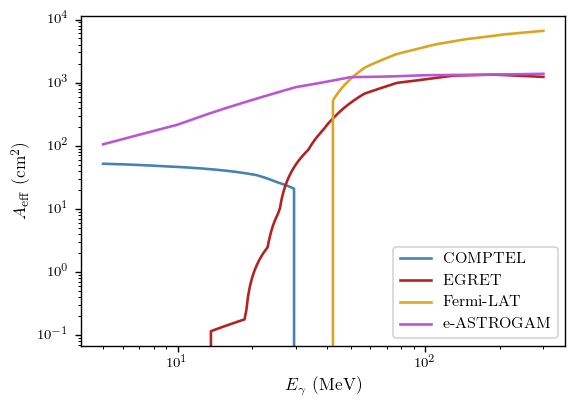

In [6]:
import numpy as np
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import A_eff_comptel, A_eff_egret, A_eff_fermi, A_eff_e_astrogam

e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

plt.plot(e_gams, A_eff_comptel(e_gams), label="COMPTEL")
plt.plot(e_gams, A_eff_egret(e_gams), label="EGRET")
plt.plot(e_gams, A_eff_fermi(e_gams), label="Fermi-LAT")
plt.plot(e_gams, A_eff_e_astrogam(e_gams), label="e-ASTROGAM")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$A_{\mathrm{eff}}$ (cm$^2$)")